## Origial tutorial: https://stackabuse.com/python-for-nlp-neural-machine-translation-with-seq2seq-in-keras/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
import os, sys

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.utils as utils
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [3]:
BATCH_SIZE = 64
EPOCHS = 20
LSTM_NODES =256
NUM_SENTENCES = 10000
MAX_SENTENCE_LENGTH = 50
MAX_NUM_WORDS = 20000 # Vocabulary size
EMBEDDING_SIZE = 100

In [4]:
input_sentences = []
output_sentences = []
output_sentences_inputs = []

count = 0
for line in open('drive/MyDrive/data/fra-eng/fra.txt', encoding="utf-8"):
    count += 1

    # Stop when we take all the required number of samples
    if count > NUM_SENTENCES:
        break

    # Dont consider if its not a datapoint. (eng  fra sometext)
    if '\t' not in line:
        continue

    # Split (eng  fra sometext) into input_sentence, output and _
    input_sentence, output, _ = line.rstrip().split('\t')

    # taget output is blah blah blah<EOS>
    # taget input is <SOS> blah blah blah
    # Teacher forcing training in the decoder
    output_sentence = output + ' <eos>'
    output_sentence_input = '<sos> ' + output

    # Prepare the text dataset: input, decoder_input (<SOS> sentence), decoder_output (<EOS> sentence)
    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("num samples input:", len(input_sentences))
print("num samples output:", len(output_sentences))
print("num samples output input:", len(output_sentences_inputs))

num samples input: 10000
num samples output: 10000
num samples output input: 10000


In [5]:
print(input_sentences[172]) # input
print(output_sentences[172]) # decoder target output
print(output_sentences_inputs[172]) # decoder input

Beat it.
Pars ! <eos>
<sos> Pars !


In [10]:
# Tokenise the words; convert the words into a set of unique numbers 
input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(input_sentences)
# Using the vocabulary from the tokeniser, convert the input sentence to a sequence of 
# real valued vector
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)
print(input_integer_seq)

# build a dict of word: idx
word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)

[[10], [10], [10], [316], [316], [90], [90], [90], [90], [90], [90], [90], [90], [90], [90], [90], [90], [90], [90], [90], [90], [52], [1461], [859], [859], [859], [432], [56], [536], [536], [397], [397], [49], [49], [49], [76], [76], [76], [76], [76], [76], [76], [537], [537], [10, 64], [10, 64], [10, 64], [317], [317], [1, 62], [1, 62], [1, 66], [1, 107], [1, 107], [1, 107], [486, 41], [220], [220], [220], [220], [220], [220], [220], [220], [220], [220], [220], [220], [350], [350], [350], [166], [709], [709], [709], [153, 3], [153, 3], [153, 3], [153, 3], [710], [710], [710], [710], [108, 3], [108, 3], [18, 22], [18, 22], [18, 22], [10, 85], [10, 85], [10, 85], [45, 3], [45, 3], [45, 3], [45, 3], [45, 3], [45, 3], [1024, 32], [1024, 32], [351, 8], [351, 8], [1, 398], [1, 398], [1, 1462], [1, 1463], [1, 81], [1, 128], [1, 128], [1, 433], [1, 60], [1, 434], [1, 434], [1, 434], [1, 178], [1, 178], [5, 1464], [5, 103], [5, 103], [435], [41, 159], [41, 159], [41, 159], [41, 159], [41, 159

In [13]:
# Do the same to the decoder,
output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
# Note here we are considering both decoder input and target since
# decoder input has <SOS> andtarget has <EOS> that needs to be torkenised
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

Total unique words in the output: 5676
Length of longest sentence in the output: 11


In [14]:
# Since the sentences are variable length pad them, so all has the same maxlen
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[172]:", encoder_input_sequences[172])

encoder_input_sequences.shape: (10000, 5)
encoder_input_sequences[172]: [  0   0   0 160   3]


In [15]:
# Do the same padding for decoder inputs
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[172]:", decoder_input_sequences[172])

decoder_input_sequences.shape: (10000, 11)
decoder_input_sequences[172]: [  2 227   4   0   0   0   0   0   0   0   0]


In [16]:
# Do the same padding for decoder targets
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences.shape:", decoder_output_sequences.shape)
print("decoder_output_sequences[172]:", decoder_output_sequences[172])

decoder_output_sequences.shape: (10000, 11)
decoder_output_sequences[172]: [227   4   1   0   0   0   0   0   0   0   0]


In [17]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

# Glove is another word embedding method like word2vec
glove_file = open(r'drive/MyDrive/embeddings/glove.6B.100d.txt', encoding="utf8")

# The glove file has the embeddings for all the words in a table:
# word   embedding
# go:    [3.1, 5.2, 9.6 5.9, ...] 
for line in glove_file:
    records = line.split()
    word = records[0] # The word idx
    vector_dimensions = asarray(records[1:], dtype='float32') # Embedding vector
    embeddings_dictionary[word] = vector_dimensions # Dict word: embedding vector
glove_file.close()

In [23]:
# The word2idx dictionary found, could be smaller than the MAX_NUM_WORDS
# so we take only the word2idx + 1; +1 because the indexing starts with 1;
# why indexing start with 1? because 0 is for 0 padding
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = zeros((num_words, EMBEDDING_SIZE))
# print(embedding_matrix.shape)
print(word2idx_inputs)
for word, index in word2idx_inputs.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
embedding_matrix[0]

{'i': 1, 'tom': 2, 'it': 3, 'you': 4, "i'm": 5, 'a': 6, 'is': 7, 'me': 8, 'he': 9, 'go': 10, 'we': 11, "you're": 12, 'was': 13, 'be': 14, 'are': 15, "it's": 16, "don't": 17, 'get': 18, 'do': 19, 'this': 20, "we're": 21, 'up': 22, 'that': 23, 'can': 24, 'to': 25, 'the': 26, 'come': 27, "i'll": 28, 'they': 29, 'did': 30, 'take': 31, 'in': 32, 'out': 33, 'am': 34, 'have': 35, 'let': 36, 'not': 37, "that's": 38, 'keep': 39, 'here': 40, 'no': 41, 'stay': 42, "he's": 43, "they're": 44, 'got': 45, 'him': 46, 'she': 47, 'my': 48, 'stop': 49, "tom's": 50, 'us': 51, 'who': 52, 'need': 53, 'like': 54, 'love': 55, 'help': 56, 'how': 57, 'look': 58, 'what': 59, 'lost': 60, 'back': 61, 'see': 62, 'home': 63, 'on': 64, 'all': 65, 'try': 66, 'must': 67, 'away': 68, 'please': 69, 'down': 70, "let's": 71, 'want': 72, 'busy': 73, 'saw': 74, 'feel': 75, 'wait': 76, 'your': 77, 'so': 78, 'good': 79, 'felt': 80, 'know': 81, 'leave': 82, 'one': 83, 'hurt': 84, 'now': 85, "we'll": 86, 'again': 87, 'them': 88,

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [26]:
# Make a keras embedding layer to process the input tokens to embeddings
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding
embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

In [27]:
# One hot vector to store the decoded outputs
decoder_targets_one_hot = np.zeros((
        len(input_sentences), # number of training sentences
        max_out_len, # Max length of output sequence
        num_words_output # Output vocabulary size
    ),
    dtype='float32'
)

In [28]:
# Encode the decoder targets
for i, d in enumerate(decoder_output_sequences):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

## Training the NMT

In [39]:
# Build the encoder LSTM model
encoder_inputs_placeholder = Input(shape=(max_input_len,)) # Input layer that takes (batch_size, Max_seq_len, vocab_size)
x = embedding_layer(encoder_inputs_placeholder) # Forward the tokens through embedding layer to get the embedding vector
encoder = LSTM(LSTM_NODES, return_state=True) # Encoder LSTM model

encoder_outputs, h, c = encoder(x) # Encoder outputs the final hidden state, final hidden state, final cell state
encoder_states = [h, c] # pack both hidden and cell states together

In [38]:
# LSTMs in tensorflow: https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
inputs = tf.random.normal((32, 10, 8))
lstm_layer = tf.keras.layers.LSTM(4, return_state=False, return_sequences=False) # Outputs just the last hidden state of the cell
print(lstm_layer(inputs).shape)
print()

lstm_layer = tf.keras.layers.LSTM(4, return_state=True, return_sequences=False) # Outputs just the last hidden and cell state of the cell
print(lstm_layer(inputs)[0].shape)
print(lstm_layer(inputs)[1].shape)
print(lstm_layer(inputs)[2].shape)
tf.debugging.assert_equal(lstm_layer(inputs)[0], lstm_layer(inputs)[1])
print()

lstm_layer = tf.keras.layers.LSTM(4, return_state=True, return_sequences=True) # Outputs all the hidden states at each time step, last hidden state, last cell state
print(lstm_layer(inputs)[0].shape)
print(lstm_layer(inputs)[1].shape)
print(lstm_layer(inputs)[2].shape)

(32, 4)

(32, 4)
(32, 4)
(32, 4)

(32, 10, 4)
(32, 4)
(32, 4)


In [41]:
# Build the decoder
decoder_inputs_placeholder = Input(shape=(max_out_len,))

decoder_embedding = Embedding(num_words_output, LSTM_NODES) # This is an embedding layer without Glove, 
# so that means, this embedding layer will be trained self-supervisely (A Design choice)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
# Note here the decoder outputs sequence of hidden states, final hidden state, final cell state
# The decoder is initialised with the encoders final states [h c]
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

In [42]:
# Output layer of the decoder
# It takes an input of batch_size, max_seq_len, vocab_size and outputs batch_size, max_seq_len, vocab_size
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [43]:
# Build and compile the model
model = Model([encoder_inputs_placeholder,
  decoder_inputs_placeholder], decoder_outputs)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

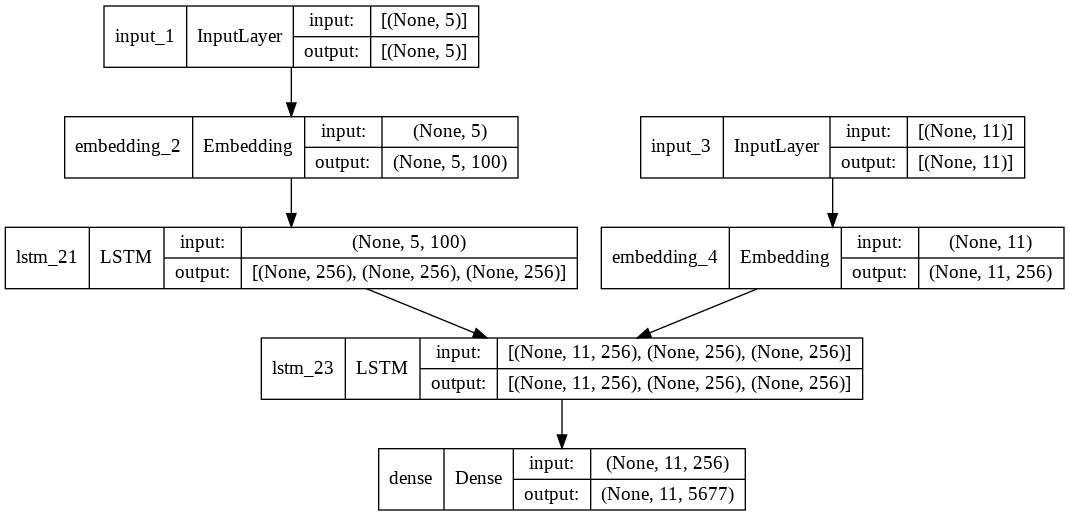

In [44]:
from keras.utils.vis_utils import plot_model
# Visualise the model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Train the model
r = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
)

Epoch 1/20
141/141 [==============================] - 11s 44ms/step - loss: 2.2560 - accuracy: 0.6933 - val_loss: 2.2513 - val_accuracy: 0.6673
Epoch 2/20
141/141 [==============================] - 5s 35ms/step - loss: 1.6517 - accuracy: 0.7493 - val_loss: 2.0773 - val_accuracy: 0.6967
Epoch 3/20
141/141 [==============================] - 5s 33ms/step - loss: 1.4421 - accuracy: 0.7800 - val_loss: 1.9333 - val_accuracy: 0.7284
Epoch 4/20
141/141 [==============================] - 5s 34ms/step - loss: 1.3017 - accuracy: 0.8002 - val_loss: 1.8167 - val_accuracy: 0.7431
Epoch 5/20
141/141 [==============================] - 5s 34ms/step - loss: 1.1987 - accuracy: 0.8127 - val_loss: 1.7463 - val_accuracy: 0.7533
Epoch 6/20
141/141 [==============================] - 5s 34ms/step - loss: 1.1186 - accuracy: 0.8214 - val_loss: 1.7188 - val_accuracy: 0.7622
Epoch 7/20
141/141 [==============================] - 5s 34ms/step - loss: 1.0488 - accuracy: 0.8294 - val_loss: 1.7292 - val_accuracy: 0.762

# Inference: Sample text

In [45]:
# Make an encoder model that take a source input and produce the final states
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

In [ ]:
# The state placeholders to pass the decoder state at each time step
# (encoder_final_state, <SOS>) -> (decoder_state_1, first_word) -> (decoder_state_2, second word) -> .....
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

In [ ]:
# Since we are giving one step at a time the input will be (1, 1, vocab_size)
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [ ]:
# Call the decoder to use one step at a time, initialised with decoder state placeholder (we can fill this
# state placeholder as we wish when we sample one step at a time)
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

In [ ]:
# Pack the decoder state, we need to pass them to the next time step
decoder_states = [h, c]
# Decoder output layer that predict the word
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
# Build the decoder model that takes inputs: 1 step input + previous decoder state
# and output: decoder output word + current decoder state (to pass to the next time step)
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

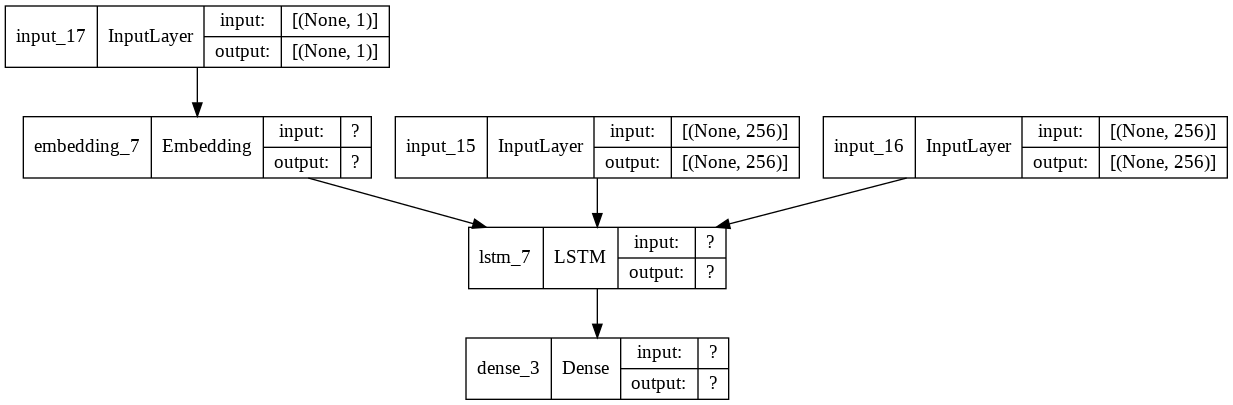

In [ ]:
plot_model(decoder_model, to_file='model_plot_dec.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Reverse the word indxing: word: index -> index: word. So when the decoder
# predicts a word index (argmax of a onehot vector) we can get the corresponding word
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}
print(idx2word_target)

{1: '<eos>', 2: '<sos>', 3: 'je', 4: '!', 5: 'tom', 6: '?', 7: 'suis', 8: 'nous', 9: 'il', 10: "c'est", 11: 'est', 12: 'vous', 13: 'de', 14: 'ne', 15: "j'ai", 16: 'pas', 17: 'le', 18: 'à', 19: 'me', 20: 'la', 21: 'a', 22: 'un', 23: 'en', 24: 'tu', 25: 'une', 26: 'tom.', 27: 'les', 28: 'ça', 29: 'sommes', 30: 'est-ce', 31: 'êtes', 32: 'qui', 33: 'sont', 34: 'es', 35: 'soyez', 36: 'que', 37: 'ils', 38: 'pas.', 39: 'va', 40: 'du', 41: 'sois', 42: 'elle', 43: 'fait', 44: 'te', 45: 'des', 46: 'elles', 47: 'été', 48: 'y', 49: 'fais', 50: 'ça.', 51: 'êtes-vous', 52: 'tout', 53: 'faut', 54: 'se', 55: 'était', 56: 'ai', 57: 'restez', 58: 'besoin', 59: 'avons', 60: "m'a", 61: 'bien.', 62: 'ce', 63: "l'ai", 64: 'reste', 65: 'au', 66: 'on', 67: 'mon', 68: "s'est", 69: "j'aime", 70: 'peux', 71: 'faites', 72: "j'étais", 73: 'train', 74: 'es-tu', 75: 'aller.', 76: 'partir.', 77: 'prends', 78: "c'était", 79: "l'air", 80: 'moi.', 81: 'sens', 82: "n'est", 83: 'puis-je', 84: 'ici.', 85: 'ont', 86: "j'en"

In [ ]:
# Infer the language model
def translate_sentence(input_seq):
    # Given a source sentence get the final encoder states
    states_value = encoder_model.predict(input_seq)
    # the inputs to the decoder (1, 1) -> embedding (1, 256)
    target_seq = np.zeros((1, 1))
    # The first word <SOS>
    target_seq[0, 0] = word2idx_outputs['<sos>']
    print(word2idx_outputs['<sos>'])
    # get the <EOS> index, so we can stop the sampling if <EOS> is reached
    eos = word2idx_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        # Sample from the decoder, given the decoder first input + encoder state
        # then the decoder second input (decoder first output) + previous current state
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        # Get the index from the predicted vector of softmax probabilities
        idx = np.argmax(output_tokens[0, 0, :])

        # If the end of sentence is reached terminate
        if eos == idx:
            break

        word = ''

        # If not the index of <SOS> and <EOS> append the predicted word to 
        # the sequence
        if idx > 2:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # prepare the input for the next time step
        target_seq[0, 0] = idx
        # prepare the current states for the next time step
        states_value = [h, c]

    # Concatenate the words with a space to build the sentence
    return ' '.join(output_sentence)

In [ ]:
# Sample a random source sentence and get the translation
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

2
-
Input: Tom took over.
Response: tom a pris la relève.
